# Proyecto Final

## Model Training

Para este proyecto se creó un *dataset* de imágenes de alimentos descargadas de [Walmart Centroamérica](https://centroamerica.walmart.com/1/browse/items). Específicamente de bebidas y snacks con dos tipos de *labels*. Unos *labels* que clasifican entre **bebidas** y **snack**. Y otros *labels* clasificados por el tipo de material. Para el siguiente proyecto se usará la primera clasificación de *labels* para determinar si se tienen **bebidas** o **snacks**.

Importar librerías

In [86]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Input,Conv2D,ReLU,BatchNormalization,Add,MaxPooling2D,Dropout,Flatten,Dense,AveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from tensorflow import Tensor

from IPython.display import display
from PIL import Image

Carpetas de imágenes separadas por categoría

In [2]:
ls "Datasets/Food Dataset/"

Bebibas/  Bebidas_all/  Snacks/  Snacks_all/  dataset_info.csv


Carga el dataset con la información de las imágenes

In [3]:
path = "Datasets/Food Dataset/"
info = "dataset_info.csv"
df = pd.read_csv(path+info)
df.head()

,image name,type,Descripción,Category,Material,Precio (Colones)
0,744100161906,jpg,Jugo Dos Pinos Naranja 100% Natural - 1800 ml,Bebibas,Botella de plástico,2595
1,744107412727,jpg,Agua De Pipa – 1800 ml,Bebibas,Botella de plástico,4100
2,1630016574,jpg,Jugo Florida Natural Naranja No Pulp – 2630 ml,Bebibas,Botella de plástico,6650
3,4850020277,jpg,Jugo Naranja Con Calcio Tropicana – 1530 ml,Bebibas,Botella de plástico,3550
4,744107411249,jpg,Agua De Pipa – 8 oz,Bebibas,Botella de plástico,900


Número de muestras por categoría

In [4]:
categories = np.unique(df['Category'],return_counts=True)
category_names = categories[0]
category_count = categories[1]
for i,c in enumerate(category_names): print(c," : ",category_count[i])

Bebibas  :  199
Snacks  :  199


Número de muestras por tipo de material

In [5]:
materials = np.unique(df['Material'],return_counts=True)
material_names = materials[0]
material_count = materials[1]
for i,m in enumerate(material_names): print(m," : ",material_count[i])

Bolsa Aluminio  :  149
Bolsa plástico  :  44
Botella de plástico  :  139
Botella de vidrio  :  1
Lata de aluminio  :  7
Paquete plástico  :  3
Tarro Cartón  :  3
Tetra brick  :  52


Mostrar imagen

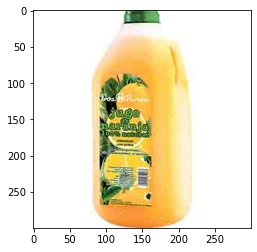

rows: 300 columns: 300 channels: 3


In [6]:
filecategory = df['Category'][0]
filename = df['image name'][0]
filetype = df['type'][0]
file = path+filecategory+"/"+str(filename)+"."+filetype
image = keras.preprocessing.image.load_img(file)
plt.imshow(image)
plt.show()
rows,columns,channels = np.array(image).shape
print("rows:",rows,"columns:",columns,"channels:",channels)

Mostrar imagen redimensionada

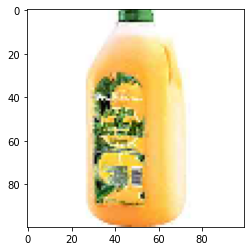

rows: 100 columns: 100 channels: 3


In [7]:
filecategory = df['Category'][0]
filename = df['image name'][0]
filetype = df['type'][0]
file = path+filecategory+"/"+str(filename)+"."+filetype
image = keras.preprocessing.image.load_img(file)
image_array = keras.preprocessing.image.img_to_array(image)
image_array = keras.preprocessing.image.smart_resize(image_array,(100,100),interpolation='bilinear')
image_array = image_array/255
plt.imshow(image_array)
plt.show()
rows,columns,channels = np.array(image_array).shape
print("rows:",rows,"columns:",columns,"channels:",channels)

Importar las imágenes de *testing* y realizar el preprocesado

In [8]:
samples = len(df)
Features = np.zeros((samples,rows,columns,channels))
Targets = np.unique(df['Category'],return_inverse=True)[1]

filecategories = df['Category']
filenames = df['image name']
filetypes = df['type']

for i,filecategory in enumerate(filecategories):
    file = path+filecategory+"/"+str(filenames[i])+"."+filetypes[i]
    image = keras.preprocessing.image.load_img(file)
    image_array = keras.preprocessing.image.img_to_array(image)
    image_array = keras.preprocessing.image.smart_resize(image_array,(rows,columns),interpolation='bilinear')
    Features[i,:,:,:] = image_array
    
Features = Features.astype('float32')
Features = Features/255

Desplegar las dimensiones del *set*

In [9]:
print(Features.shape)
print(Targets.shape)
print(np.unique(Targets,return_counts=True))

(398, 100, 100, 3)
(398,)
(array([0, 1]), array([199, 199]))


Número de categorías y conversión a vector binario

In [10]:
#set number of categories
num_category = len(np.unique(Targets))
print("categories:",num_category)
# convert class vectors to binary class matrices
Targets = keras.utils.to_categorical(Targets,num_category)

categories: 2


Dividir el *set* en *train* y *test*

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(Features,Targets,test_size = 0.2,random_state = 4)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_test:",Y_test.shape)

X_train: (318, 100, 100, 3)
X_test: (80, 100, 100, 3)
Y_train: (318, 2)
Y_test: (80, 2)


Función de entrenamiento

In [12]:
def Model_log(model,batch_size,num_epoch):
    start = time.time()
    model_log = model.fit(X_train,Y_train,
              batch_size=batch_size,
              epochs=num_epoch,
              verbose=0,
              validation_data=(X_test,Y_test))
    _, acc = model.evaluate(X_test,Y_test,verbose=0)
    print("accuracy: > %.3f" % (acc * 100.0))
    end = time.time()
    m = (end - start)/60
    m = round(m, 2)
    s = (end - start)
    s = round(s, 2)
    print(f"Training time: {m} min / {s} sec")
    return model_log

Función para graficar los resultados

In [13]:
def plot_model_log(model_log):
    fig = plt.figure()
    
    plt.subplot(2,1,1)
    plt.plot(model_log.history['accuracy'])
    plt.plot(model_log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.grid(color='b', linestyle='-', linewidth=0.25)

    plt.subplot(2,1,2)
    plt.plot(model_log.history['loss'])
    plt.plot(model_log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(color='b', linestyle='-', linewidth=0.25)

    plt.tight_layout()
    plt.show()

## Modelo 

### Teoría y modelo propuesto

#### VGG (Visual Geometry Group)

Las redes VGG fueron propuestas por Karen Simonyan y Andrew Zisserman en el artículo [VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION](https://arxiv.org/pdf/1409.1556.pdf) en 2014 para el ILSVRC challenge.

Las VGG se forman mediante grupos de bloques compuestos por 2 o 3 capas convolutivas y una capa de *pooling*. La red se forma colocando un bloque después de otro para lograr una arquitectura más profunda. Todas las capas utilizan *ReLU* como función de activación. La función de activación *ReLU* es más eficiente computacionalmente porque da como resultado un aprendizaje más rápido y también disminuye la probabilidad de que desaparezca el problema del gradiente.

<img src="VGG.jpg" />

Figura 1 [Arquitectura de VGG](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

#### ResNet (Residual Network)

Las redes ResNet fueron propuestas por Kaiming He, Xiangyu Zhang, Shaoqing Ren y Jian Sun en el artículo [Deep Residual Learning for Image Recognition](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) en 2015.

Para lograr mejores modelos se recomienda diseñar el modelo con más capa o lo que es lo mismo hacerlo más profundo. Pero para los modelos de arquitectura tradicionales se ha visto que tienen un umbral de profundidad, como se ve en la figura 1. Esto por la desaparición del gradiente.

<img src="deep_layer_problem.png" />

Figura 2 [Comparación del error por capas](https://www.mygreatlearning.com/blog/resnet/)

Para solucionar este problema los autores propusieron un bloque residual. Este bloque consiste en una conexión o salto de una capa inicial a otra capa. Matemáticamente se tiene $H(x) = f(wx + b)$ para un bloque tradicional. En el caso del bloque residual se tendría $H(x) = f(wx + b) + x$. Mediante la suma de $x$, el salto o conección de capas no adyacentes se logra resolver el problema de la desaparición del gradiente, al permitir esta ruta de acceso directo alternativo para que fluya el gradiente.

<img src="residual_block.png" />

Figura 3 [Bloque residual](https://www.mygreatlearning.com/blog/resnet/)

#### Propuesta

El modelo propuesto es es una mezcla de una red VGG usando bloques residuales. Con un saldo o conección entre la primera capa y la tercera capa del bloque residual.

In [21]:
def Modelo():
    inputs = Input(shape=(rows,columns,channels))
    tensor = inputs
    n_filters = 64
    for n in range(2):
        n_filters = n_filters*2**n
        tensor_0 = Conv2D(filters=n_filters,kernel_size=(3,3),activation='relu',kernel_initializer='he_uniform',strides=1,padding="same")(tensor)
        tensor_1 = Conv2D(filters=n_filters,kernel_size=(3,3),activation='relu',kernel_initializer='he_uniform',strides=1,padding="same")(tensor_0)
        tensor_2 = Conv2D(filters=n_filters,kernel_size=(3,3),activation='relu',kernel_initializer='he_uniform',strides=1,padding="same")(tensor_1)
        tensor = Add()([tensor_0,tensor_2])
        tensor = ReLU()(tensor)
        tensor = MaxPooling2D(pool_size=(2,2))(tensor)
    
    tensor = Flatten()(tensor)
    tensor = Dense(128,activation='relu',kernel_initializer='he_uniform')(tensor)
    tensor = Dropout(0.5)(tensor)
    outputs = Dense(num_category,activation='softmax')(tensor)
    model = Model(inputs,outputs)
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
    return model

Visualización de la arquitectura del modelo

768 1844


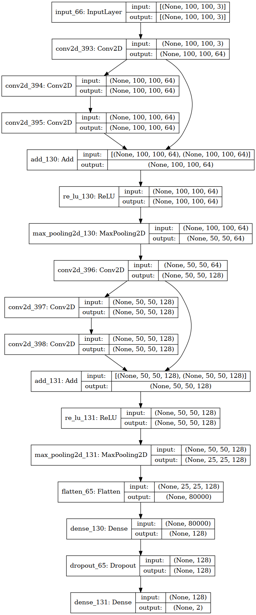

In [85]:
model = Modelo()
model_image = "model.png"
keras.utils.plot_model(model,to_file=model_image,show_shapes=True)
model_image = Image.open(model_image)
width,height = model_image.size
print(width,height)
new_size = (round(width/3),round(height/3))
model_image.resize(new_size)

Visualización del modelo

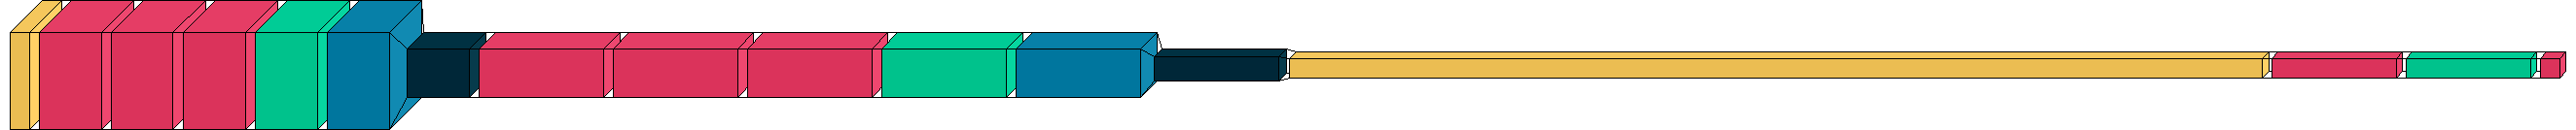

In [91]:
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(model,scale_xy=1,scale_z=1,max_z=1000)

Entrenamiento del modelo

In [19]:
model_log = Model_log(model,batch_size=128,num_epoch=20)

accuracy: > 83.750
Training time: 30.58 min / 1834.58 sec


Accuracy & Loss plots

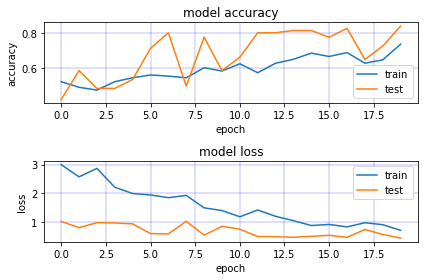

In [20]:
plot_model_log(model_log)

Guardar el modelo

In [21]:
model.save("food_classifier_model.h5")

### Referencias

* [Walmart Centroamérica](https://centroamerica.walmart.com/1/browse/items)

* [VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION](https://arxiv.org/pdf/1409.1556.pdf)

* [VGG-16 | CNN model](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

* [Deep Residual Learning for Image Recognition](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

* [Introduction to Resnet or Residual Network](https://www.mygreatlearning.com/blog/resnet/)